## Classifier Performance: selecting for reobservation
#### Plot to show performance when selecting Lya QSOs for reobservation
In this notebook, we load the results from all of our classifiers on a DESI-like subset of the BOSS DR12Q Superset, and compare the results in the context of selecting high-z Lya QSOs for reobservation. We define different strategies for combining the classifiers' classifications, and assess which of these is preferable.

In [36]:
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import fitsio
from astropy.io import fits
from astropy.table import Table, join
from tensorflow.keras.models import load_model
from quasarnet.io import read_data
from quasarnet.utils import process_preds, absorber_IGM, Wave
%matplotlib inline

from quasarnet.notebook_utils import *

from utils import *

In [51]:
qnet_path = '/global/homes/j/jfarr/Projects/QuasarNET/'
figsize = (12,8)
fontsize = 18

plt.rc('font', size=fontsize)

### Load the results from the different classifiers

In [65]:
## RR parameters

## QN parameters
n_lines = 1
c_th = 0.8
include_cmax_qn = True
include_cmax2_qn = True

## SQ parameters
p_min = 0.32
include_p_sq = True

In [66]:
f_truth = qnet_path+'/data/truth_DR12Q.fits'
truth = read_truth([f_truth])

In [67]:
data = {}

## Load the VI data.
#f_sdrq = '/global/projecta/projectdirs/sdss/staging/dr12/boss/qso/DR12Q/Superset_DR12Q.fits'
#data['VI'] = load_sdrq_data(f_sdrq)

## Load the RR data.
f_rr = '../results/rr_results/rr_sdr12q.fits'
data['RR'] = load_rr_data(f_rr)

## Load the new RR data.
f_rr = '../results/rr_results/rr_sdr12q_test.fits'
data['RRnew'] = load_rr_data(f_rr)

## Load the RRngp data.
f_rr = '../results/rr_results/rr_sdr12q_ngp.fits'
data['RRngp'] = load_rr_data(f_rr)

## Load the RRngp random exp data.
f_rr = '../results/rr_results/rr_sdr12q_ngprandexp.fits'
data['RRngp randexp'] = load_rr_data(f_rr)

## Load the RRngp random exp data.
f_rr = '../results/rr_results/rr_sdr12q_ngpbestexp.fits'
data['RRngp bestexp'] = load_rr_data(f_rr)

## Load BOSS pipeline data.
f_pipe = '../results/dr12pipe_results/dr12pipe_sdr12q.fits'
#f_pipe = '../dr14pipe_results/dr14pipe_sdr12q.fits'
data['PIPE'] = load_rr_data(f_pipe)

## Load the QN data.
f_qn = '../results/qn_results/qn_performance_vs_snr/qn_modelsingexp_testsingexp.fits'
data['QN'] = load_qn_data(f_qn,n_lines=n_lines,c_th=c_th,include_cmax=include_cmax_qn,include_cmax2=include_cmax2_qn)

## Load the QN data.
f_qn = '../results/qn_results/qn_performance_vs_snr/qn_modelcoadd_testcoadd.fits'
data['QNcoadd'] = load_qn_data(f_qn,n_lines=n_lines,c_th=c_th,include_cmax=include_cmax_qn,include_cmax2=include_cmax2_qn)

## Load the SQ data.
# TODO: Need results for SQUEzE on single exposure data.
f_sq = '../results/sq_results/sq_sdr12q.fits'
data['SQcoadd'] = load_sq_data(f_sq,p_min=p_min,include_p=include_p_sq)

### Find the set of common targetids, and reduce all data to that set
This finds which targetids* are common to all datasets, and removes any that are not common. It then matches the data from each classifier to each targetid, and produces a single data table.

\* targetid = plate$\times$1000000000 + mjd$\times$10000 + fiber

In [68]:
data_table = reduce_data_to_table(data,truth,
                                  include_cmax_qn=include_cmax_qn,
                                  include_cmax2_qn=include_cmax2_qn,
                                  include_p_sq=include_p_sq)
data_table[:5]

INFO: 255814 common targetids


THING_ID,TARGETID,PLATE,MJD,FIBERID,ZCONF_PERSON,Z_VI,CLASS_VI,ISQSO_VI,Z_RR,Z_RRnew,Z_RRngp,Z_RRngp randexp,Z_RRngp bestexp,Z_PIPE,Z_QN,Z_QNcoadd,Z_SQcoadd,CLASS_RR,CLASS_RRnew,CLASS_RRngp,CLASS_RRngp randexp,CLASS_RRngp bestexp,CLASS_PIPE,CLASS_QN,CLASS_QNcoadd,CLASS_SQcoadd,ISQSO_RR,ISQSO_RRnew,ISQSO_RRngp,ISQSO_RRngp randexp,ISQSO_RRngp bestexp,ISQSO_PIPE,ISQSO_QN,ISQSO_QNcoadd,ISQSO_SQcoadd,CMAX_QN,CMAX_QNcoadd,CMAX2_QN,CMAX2_QNcoadd,P_SQcoadd,ZWARN_RR,ZWARN_RRnew,ZWARN_RRngp,ZWARN_RRngp randexp,ZWARN_RRngp bestexp,ZWARN_PIPE
int64,int64,int64,int64,int64,int64,float64,str8,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,str8,str8,str8,str8,str8,str8,str8,str8,bool,bool,bool,bool,bool,bool,bool,bool,bool,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64
391033059,3980553310001,3980,55331,1,2,0.433,GALAXY,False,0.433,0.433,0.433,0.433,0.433,0.433,0.447,0.438,0.919,GALAXY,GALAXY,GALAXY,GALAXY,GALAXY,GALAXY,QSO,NONQSO,QSO,False,False,False,False,False,False,True,False,True,1.000,0.902,0.994,0.214,0.803,0,0,0,0,0,0
391032962,3980553310002,3980,55331,2,2,2.371,QSO,True,1.291,0.382,0.382,0.382,0.382,2.383,2.378,2.373,2.464,QSO,GALAXY,GALAXY,GALAXY,GALAXY,QSO,QSO,QSO,QSO,True,False,False,False,False,True,True,True,True,1.000,1.000,1.000,1.000,0.861,0,0,0,0,0,0
391032942,3980553310003,3980,55331,3,2,0.416,QSO,True,0.416,0.416,0.416,0.416,0.416,0.416,0.418,0.409,0.420,QSO,QSO,QSO,QSO,QSO,QSO,QSO,QSO,QSO,True,True,True,True,True,True,True,True,True,1.000,1.000,1.000,1.000,0.742,0,0,0,0,0,0
391033364,3980553310006,3980,55331,6,2,0.000,STAR,False,-0.001,1.050,0.927,0.994,1.004,2.098,0.725,0.557,1.174,STAR,GALAXY,GALAXY,GALAXY,GALAXY,QSO,NONQSO,NONQSO,NONQSO,False,False,False,False,False,True,False,False,False,0.000,0.000,0.000,0.000,0.167,0,4,4,4,0,4
391032976,3980553310007,3980,55331,7,2,2.196,QSO,True,2.194,2.193,2.193,2.196,2.193,2.194,2.195,2.190,2.193,QSO,QSO,QSO,QSO,QSO,QSO,QSO,QSO,QSO,True,True,True,True,True,True,True,True,True,1.000,1.000,1.000,1.000,0.993,0,0,0,0,0,0


In [69]:
# Include only objects in the data table that have the highest confidence level.
data_table = data_table[data_table['ZCONF_PERSON']==2]
len(data_table)

250382

RR finds 96.30% high-z QSOs (94120/97737)
RRnew finds 95.96% high-z QSOs (93789/97737)


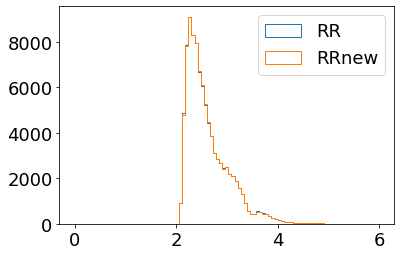

In [70]:
## Test RR
dv_max = 6000 #km/s
bins = np.linspace(0.0,6.0,100)
for c in ['RR','RRnew']:
    zgood = ((data_table['Z_VI']>-1) & 
             (abs(data_table['Z_{}'.format(c)]-data_table['Z_VI']) < dv_max*(1+data_table['Z_VI'])/300000.))
    #w = data_table['ISQSO_VI'] & data_table['ISQSO_{}'.format(c)] & (~zgood) & (data_table['Z_{}'.format(c)]>=2.1)
    #w = (((~data_table['ISQSO_{}'.format(c)]) | (data_table['ISQSO_{}'.format(c)] & (data_table['Z_{}'.format(c)]<2.1)))
    #     & (data_table['ISQSO_VI'] & (data_table['Z_VI']>=2.1)))
    w = ((data_table['ISQSO_{}'.format(c)] & (data_table['Z_{}'.format(c)]>=2.1))
         & (data_table['ISQSO_VI'] & (data_table['Z_VI']>=2.1)))
    wtrue = (data_table['ISQSO_VI'] & (data_table['Z_VI']>=2.1))
    print('{} finds {:2.2%} high-z QSOs ({}/{})'.format(c,w.sum()/wtrue.sum(),w.sum(),wtrue.sum()))
    plt.hist(data_table['Z_VI'][w],bins=bins,histtype='step',label=c)
plt.legend()
plt.show()

### Evaluate performance of classifiers at selecting for reobservation.
xxx

In [71]:
def make_plot(fig,ax,data_table,strategies,filename,c_th,eff_area,dv_max,zcut=2.1,ymin=0.94,xmin=47.,xmax=52.):
    
    # determine the true classifications
    isqso_truth = (data_table['ISQSO_VI'])
    isgal_truth = (data_table['CLASS_VI']=='GALAXY')
    isstar_truth = (data_table['CLASS_VI']=='STAR')
    isbad = ((data_table['CLASS_VI']=='BAD') | (data_table['ZCONF_PERSON']!=2))
    highz_truth = data_table['Z_VI']>=zcut
    nhighz_truth = (isqso_truth & highz_truth).sum()

    for s in strategies.keys():
        if ('QN' in s) & ('SQ' in s):
            pass
        
        elif ('QN' in s) | ('SQ' in s):
            for i,cth in enumerate(c_th):
                w = strategies[s]['w'][i]
                strategies[s]['nhighz_flagged'][i] = (w).sum()
                strategies[s]['nhighz_truth_flagged'][i] = (isqso_truth&highz_truth&w).sum()

                if np.isclose(cth,0.6):
                    print(s,cth)
                    print('true hz qsos:',nhighz_truth)
                    print('obj flagged:',strategies[s]['nhighz_flagged'][0])
                    print('true hz qsos flagged:',strategies[s]['nhighz_truth_flagged'][0])
                    print('stars selected:',(isstar_truth&w).sum())
                    print('gal selected:',(isgal_truth&w).sum())
                    print('lowz qso selected:',(isqso_truth&(~highz_truth)&w).sum())
                    print('')
             
        else:
            w = strategies[s]['w'][0]
            strategies[s]['nhighz_flagged'][0] = (w).sum()
            strategies[s]['nhighz_truth_flagged'][0] = (isqso_truth&highz_truth&w).sum()
            zwarn = data_table['ZWARN_{}'.format(s)]>0
            print(s)
            print('true hz qsos:',nhighz_truth)
            print('obj flagged:',strategies[s]['nhighz_flagged'][0])
            print('true hz qsos flagged:',strategies[s]['nhighz_truth_flagged'][0])
            print('obj with zwarn:',(zwarn).sum())
            print('true hz qsos with zwarn:',(highz_truth&isqso_truth&zwarn).sum())
            print('true hz qsos with zwarn missed:',(highz_truth&isqso_truth&zwarn&(~strategies[s]['w'][0])).sum())
            print('stars selected:',(isstar_truth&w).sum())
            print('gal selected:',(isgal_truth&w).sum())
            print('lowz qso selected:',(isqso_truth&(~highz_truth)&w).sum())
            print('')
 
    for s in strategies.keys():
        reobs_dens = strategies[s]['nhighz_flagged']/eff_area
        pli = strategies[s]['nhighz_truth_flagged']/nhighz_truth
        if len(reobs_dens)>1:
            ax.plot(reobs_dens,pli,c='grey',marker=strategies[s]['marker'],label=s,zorder=2)
            points = ax.scatter(reobs_dens,pli,c=strategies[s]['color'],marker=strategies[s]['marker'],s=100,zorder=3)
        else:
            points = ax.scatter(reobs_dens,pli,c=strategies[s]['color'],marker=strategies[s]['marker'],s=100,label=s,zorder=3)
    
    # Colour bar
    fig.subplots_adjust(right=0.87)
    cbar_ax = fig.add_axes([0.89, 0.15, 0.02, 0.7])
    cb = fig.colorbar(points,label=r'$c_{th}$',cax=cbar_ax)
    cb.mappable.set_clim(vmin=cth_min,vmax=cth_max)

    ax.axvline(x=n_highz_desi,c='k',zorder=1,ls='--')
    #text = 'assumed number density of\n'+r'high-$z$ QSOs in DESI [sqd$^{-1}$]'
    #ax.text(50.,1.004,text,va='center',ha='center')

    ax.set_ylabel(r'fraction of high-$z$ QSOs reobserved')
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,1.00)
    ax.grid()
    ax.legend(loc=4,ncol=1)
    ax.set_xlabel(r'number density of fibers allocated to reobservations [sqd$^{-1}$]')
    ax.set_axisbelow(True)

    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0,decimals=0))

    # Shaded region.
    x = np.linspace(n_highz_desi*0.5,n_highz_desi*1.5,101)
    y = x/n_highz_desi
    y[x>n_highz_desi] = 1.
    ax.fill_between(x,y,np.ones_like(y)*1.1,edgecolor='darkgrey',facecolor='none',hatch='\\')

    """# Dashed lines for purities.
    p_values = [0.99,0.98,0.97,0.96,0.95]
    for p in p_values:
        p_contour = (x/50)*(p)
        ax.plot(x,p_contour,c='darkgrey')"""
    
    #plt.tight_layout()
    fig.subplots_adjust(wspace=0.1)
    plt.savefig(filename)
    plt.show()

    return

RR [48.42082647] [0.96286615]


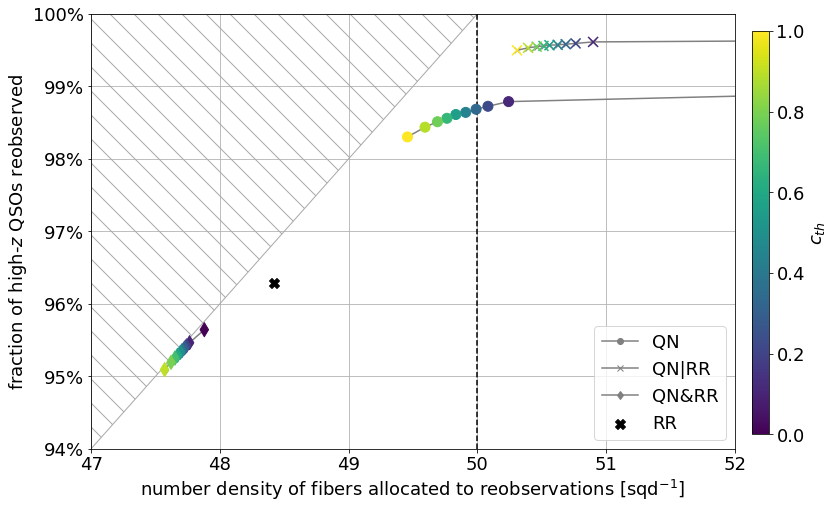

In [10]:
## Standard version of plot

# Number of expected high-z QSOs per square degree in DESI
n_highz_desi = 50
eff_area = ((data_table['ISQSO_VI'] & (data_table['ZCONF_PERSON']==2) & (data_table['Z_VI']>=2.1)).sum())/n_highz_desi

# Cut to define high-z QSOs.
zcut = 2.1
# Maximum velocity error to be considered a correct classification.
dv_max = 6000. # km/s

# QN confidence thresholds.
cth_min = 0.0
cth_max = 1.0
n_int = 10
c_th = np.arange(cth_min,cth_max,(1/n_int)*(cth_max-cth_min))

# QN classifications.
highz_qn = data_table['Z_QN']>=zcut

# RR classifications.
isqso_rr = data_table['ISQSO_RR']
highz_rr = data_table['Z_RR']>=zcut

# Define the strategies.
strategies = {}

strategies['QN'] = {'w': [(data_table['CMAX_QN']>cth)&(data_table['Z_QN']>zcut) for cth in c_th],
                    'nhighz_flagged': np.zeros(c_th.shape),
                    'nhighz_truth_flagged': np.zeros(c_th.shape),
                    'color': c_th,
                    'marker': 'o',
                   }

strategies['RR'] = {'w': [isqso_rr & highz_rr],
                    'nhighz_flagged': np.zeros(1),
                    'nhighz_truth_flagged': np.zeros(1),
                    'color': 'k',
                    'marker': 'X',
                   }

strategies['QN|RR'] = {'w': [w|(isqso_rr & highz_rr) for w in strategies['QN']['w']],
                       'nhighz_flagged': np.zeros(c_th.shape),
                       'nhighz_truth_flagged': np.zeros(c_th.shape),
                       'color': c_th,
                       'marker': 'x',
                      }

strategies['QN&RR'] = {'w': [w&(isqso_rr & highz_rr) for w in strategies['QN']['w']],
                       'nhighz_flagged': np.zeros(c_th.shape),
                       'nhighz_truth_flagged': np.zeros(c_th.shape),
                       'color': c_th,
                       'marker': 'd',
                      }

# Make the plot.
filename = '../plots/classifier_performance_selecting_for_reobservation.pdf'
fig, ax = plt.subplots(1,1,figsize=(figsize[0],figsize[1]))
xmin,xmax = (47,52)
ymin = 0.94
make_plot(fig,ax,data_table,strategies,filename,c_th,eff_area,dv_max,zcut=zcut,ymin=ymin,xmin=xmin,xmax=xmax)

RR [48.42082647] [0.96286615]
RR|zwarn [53.3848385] [0.97215856]
RR&~zwarn [48.05199456] [0.95779918]


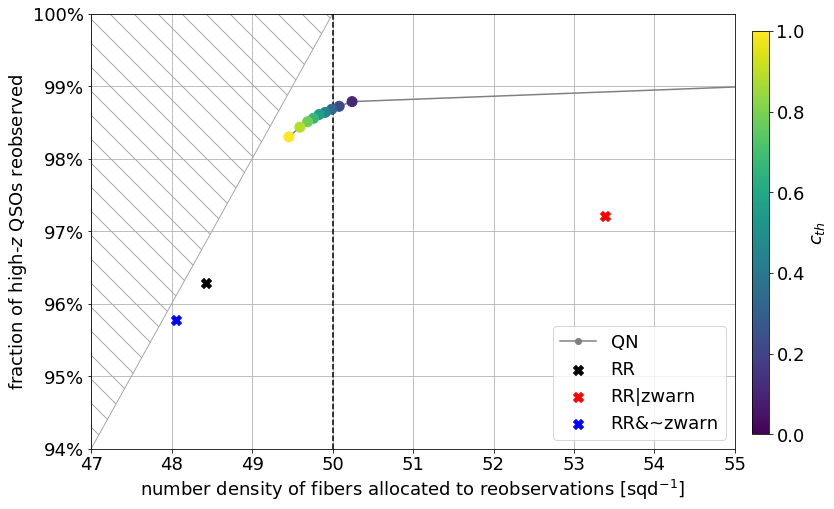

In [11]:
## Standard version of plot but with 3 RR points for including zwarn or not.

# Number of expected high-z QSOs per square degree in DESI
n_highz_desi = 50
eff_area = ((data_table['ISQSO_VI'] & (data_table['ZCONF_PERSON']==2) & (data_table['Z_VI']>=2.1)).sum())/n_highz_desi

# Cut to define high-z QSOs.
zcut = 2.1
# Maximum velocity error to be considered a correct classification.
dv_max = 6000. # km/s

# QN confidence thresholds.
cth_min = 0.0
cth_max = 1.0
n_int = 10
c_th = np.arange(cth_min,cth_max,(1/n_int)*(cth_max-cth_min))

# QN classifications.
highz_qn = data_table['Z_QN']>=zcut

# RR classifications.
zwarn = data_table['ZWARN_RR']>0
isqso_rr = data_table['ISQSO_RR']
highz_rr = data_table['Z_RR']>=zcut

# RR zwarn classifications.
zwarn = data_table['ZWARN_RR']>0
isqso_rr_zwarn = data_table['ISQSO_RR'] | zwarn
highz_rr_zwarn = (data_table['Z_RR']>=zcut) | zwarn

# RR ~zwarn classifications.
zwarn = data_table['ZWARN_RR']>0
isqso_rr_notzwarn = data_table['ISQSO_RR'] & (~zwarn)
highz_rr_notzwarn = (data_table['Z_RR']>=zcut) & (~zwarn)

# Define the strategies.
strategies = {}

strategies['QN'] = {'w': [(data_table['CMAX_QN']>cth)&(data_table['Z_QN']>zcut) for cth in c_th],
                    'nhighz_flagged': np.zeros(c_th.shape),
                    'nhighz_truth_flagged': np.zeros(c_th.shape),
                    'color': c_th,
                    'marker': 'o',
                   }

strategies['RR'] = {'w': [isqso_rr & highz_rr],
                    'nhighz_flagged': np.zeros(1),
                    'nhighz_truth_flagged': np.zeros(1),
                    'color': 'k',
                    'marker': 'X',
                   }

strategies['RR|zwarn'] = {'w': [isqso_rr_zwarn & highz_rr_zwarn],
                    'nhighz_flagged': np.zeros(1),
                    'nhighz_truth_flagged': np.zeros(1),
                    'color': 'r',
                    'marker': 'X',
                   }

strategies['RR&~zwarn'] = {'w': [isqso_rr_notzwarn & highz_rr_notzwarn],
                    'nhighz_flagged': np.zeros(1),
                    'nhighz_truth_flagged': np.zeros(1),
                    'color': 'b',
                    'marker': 'X',
                   }


# Make the plot.
filename = '../plots/classifier_performance_selecting_for_reobservation_zwarn.pdf'
fig, ax = plt.subplots(1,1,figsize=(figsize[0],figsize[1]))
xmin,xmax = (47,55)
ymin = 0.94
make_plot(fig,ax,data_table,strategies,filename,c_th,eff_area,dv_max,zcut=zcut,ymin=ymin,xmin=xmin,xmax=xmax)

RR [48.42082647] [0.96286615]
PIPE [51.47667049] [0.99700995]


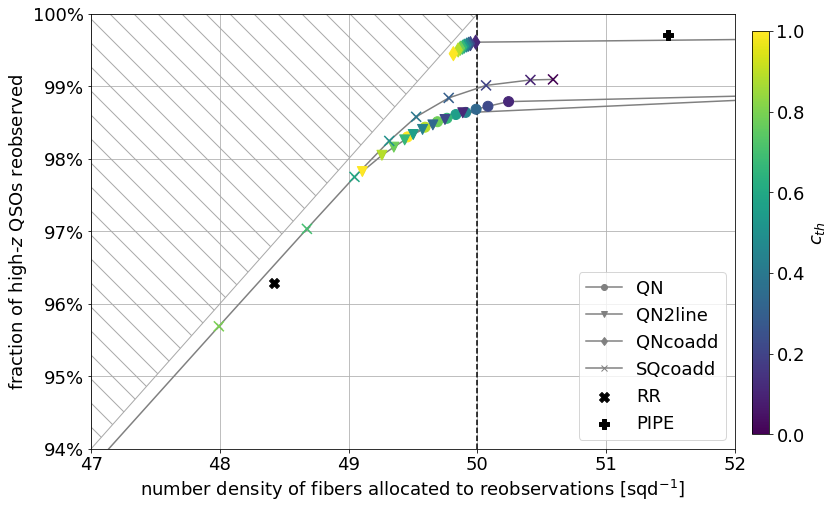

In [12]:
## Extra strategies version of plot

# Number of expected high-z QSOs per square degree in DESI
n_highz_desi = 50
eff_area = ((data_table['ISQSO_VI'] & (data_table['ZCONF_PERSON']==2) & (data_table['Z_VI']>=2.1)).sum())/n_highz_desi

# Cut to define high-z QSOs.
zcut = 2.1
# Maximum velocity error to be considered a correct classification.
dv_max = 6000. # km/s

# QN confidence thresholds.
cth_min = 0.0
cth_max = 1.0
n_int = 10
c_th = np.arange(cth_min,cth_max,(1/n_int)*(cth_max-cth_min))

# RR classifications.
isqso_rr = data_table['ISQSO_RR']
highz_rr = data_table['Z_RR']>=zcut

# PIPE classifications.
isqso_pipe = data_table['ISQSO_PIPE']
highz_pipe = data_table['Z_PIPE']>=zcut

# QN classifications.
highz_qn = data_table['Z_QN']>=zcut
highz_qncoadd = data_table['Z_QNcoadd']>=zcut

# SQ classifications.
highz_sqcoadd = data_table['Z_SQcoadd']>=zcut

# Define the strategies.
strategies = {}

strategies['QN'] = {'w': [(data_table['CMAX_QN']>cth)&(highz_qn) for cth in c_th],
                    'nhighz_flagged': np.zeros(c_th.shape),
                    'nhighz_truth_flagged': np.zeros(c_th.shape),
                    'color': c_th,
                    'marker': 'o',
                   }

strategies['RR'] = {'w': [isqso_rr & highz_rr],
                    'nhighz_flagged': np.zeros(1),
                    'nhighz_truth_flagged': np.zeros(1),
                    'color': 'k',
                    'marker': 'X',
                   }

strategies['PIPE'] = {'w': [isqso_pipe & highz_pipe],
                    'nhighz_flagged': np.zeros(1),
                    'nhighz_truth_flagged': np.zeros(1),
                    'color': 'k',
                    'marker': 'P',
                   }

strategies['QN2line'] = {'w': [(data_table['CMAX_QN']>cth)&(data_table['CMAX2_QN']>cth)&(highz_qn) for cth in c_th],
                    'nhighz_flagged': np.zeros(c_th.shape),
                    'nhighz_truth_flagged': np.zeros(c_th.shape),
                    'color': c_th,
                    'marker': 'v',
                   }

strategies['QNcoadd'] = {'w': [(data_table['CMAX_QNcoadd']>cth)&(highz_qncoadd) for cth in c_th],
                    'nhighz_flagged': np.zeros(c_th.shape),
                    'nhighz_truth_flagged': np.zeros(c_th.shape),
                    'color': c_th,
                    'marker': 'd',
                   }

strategies['SQcoadd'] = {'w': [(data_table['P_SQcoadd']>cth)&(highz_sqcoadd) for cth in c_th],
                    'nhighz_flagged': np.zeros(c_th.shape),
                    'nhighz_truth_flagged': np.zeros(c_th.shape),
                    'color': c_th,
                    'marker': 'x',
                    }

# Make the plot.
filename = '../plots/classifier_performance_selecting_for_reobservation_extrastrat.pdf'
fig, ax = plt.subplots(1,1,figsize=(figsize[0],figsize[1]))
make_plot(fig,ax,data_table,strategies,filename,c_th,eff_area,dv_max,zcut=zcut)

RR [48.42082647] [0.96286615]
PIPE [51.47667049] [0.99700995]


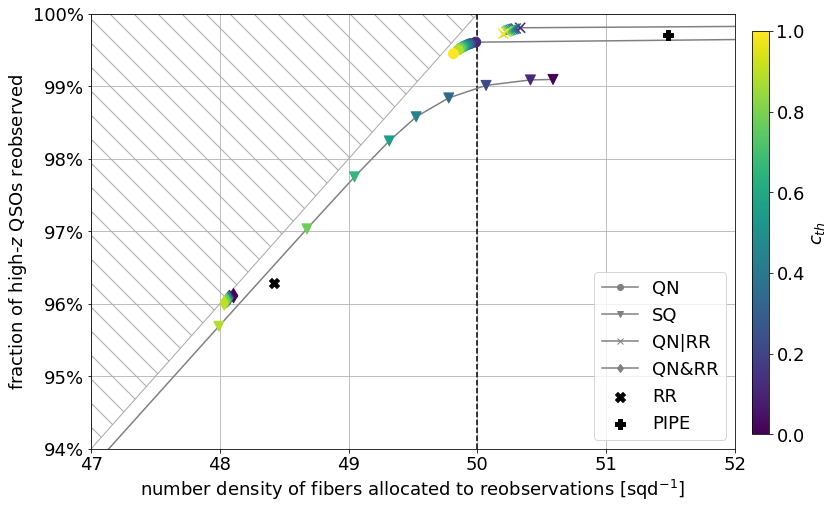

In [13]:
## Coadd only version of plot

# Number of expected high-z QSOs per square degree in DESI
n_highz_desi = 50
eff_area = ((data_table['ISQSO_VI'] & (data_table['ZCONF_PERSON']==2) & (data_table['Z_VI']>=2.1)).sum())/n_highz_desi

# Cut to define high-z QSOs.
zcut = 2.1
# Maximum velocity error to be considered a correct classification.
dv_max = 6000. # km/s

# QN confidence thresholds.
cth_min = 0.0
cth_max = 1.0
n_int = 10
c_th = np.arange(cth_min,cth_max,(1/n_int)*(cth_max-cth_min))

# RR classifications.
isqso_rr = data_table['ISQSO_RR']
highz_rr = data_table['Z_RR']>=zcut

# PIPE classifications.
isqso_pipe = data_table['ISQSO_PIPE']
highz_pipe = data_table['Z_PIPE']>=zcut

# QN classifications.
highz_qn = data_table['Z_QN']>=zcut
highz_qncoadd = data_table['Z_QNcoadd']>=zcut

# SQ classifications.
highz_sqcoadd = data_table['Z_SQcoadd']>=zcut

# Define the strategies.
strategies = {}

strategies['QN'] = {'w': [(data_table['CMAX_QNcoadd']>cth)&(highz_qncoadd) for cth in c_th],
                    'nhighz_flagged': np.zeros(c_th.shape),
                    'nhighz_truth_flagged': np.zeros(c_th.shape),
                    'color': c_th,
                    'marker': 'o',
                   }

strategies['RR'] = {'w': [isqso_rr & highz_rr],
                    'nhighz_flagged': np.zeros(1),
                    'nhighz_truth_flagged': np.zeros(1),
                    'color': 'k',
                    'marker': 'X',
                   }

strategies['PIPE'] = {'w': [isqso_pipe & highz_pipe],
                    'nhighz_flagged': np.zeros(1),
                    'nhighz_truth_flagged': np.zeros(1),
                    'color': 'k',
                    'marker': 'P',
                   }

strategies['SQ'] = {'w': [(data_table['P_SQcoadd']>cth)&(highz_sqcoadd) for cth in c_th],
                    'nhighz_flagged': np.zeros(c_th.shape),
                    'nhighz_truth_flagged': np.zeros(c_th.shape),
                    'color': c_th,
                    'marker': 'v',
                    }

strategies['QN|RR'] = {'w': [w|(isqso_rr & highz_rr) for w in strategies['QN']['w']],
                       'nhighz_flagged': np.zeros(c_th.shape),
                       'nhighz_truth_flagged': np.zeros(c_th.shape),
                       'color': c_th,
                       'marker': 'x',
                      }

strategies['QN&RR'] = {'w': [w&(isqso_rr & highz_rr) for w in strategies['QN']['w']],
                       'nhighz_flagged': np.zeros(c_th.shape),
                       'nhighz_truth_flagged': np.zeros(c_th.shape),
                       'color': c_th,
                       'marker': 'd',
                      }
# Make the plot.
filename = '../plots/classifier_performance_selecting_for_reobservation_coadd.pdf'
fig, ax = plt.subplots(1,1,figsize=(figsize[0],figsize[1]))
make_plot(fig,ax,data_table,strategies,filename,c_th,eff_area,dv_max,zcut=zcut)

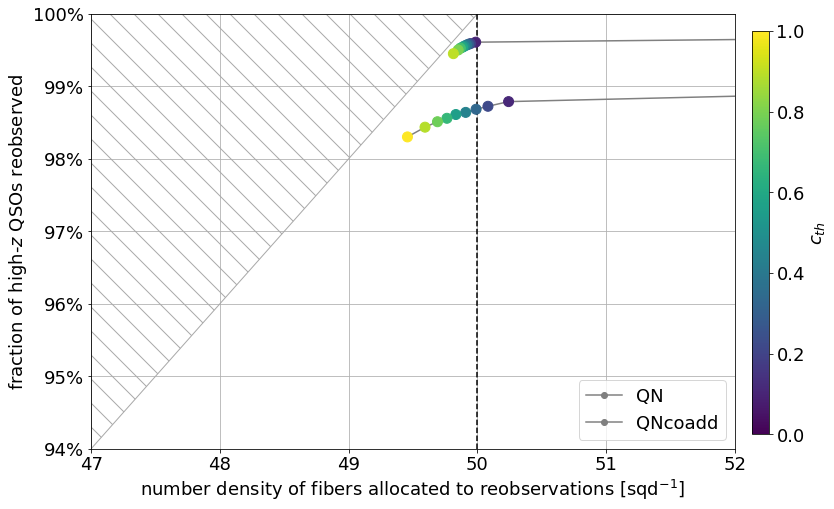

In [14]:
## QN coadd vs single exposure.

# Number of expected high-z QSOs per square degree in DESI
n_highz_desi = 50
eff_area = ((data_table['ISQSO_VI'] & (data_table['ZCONF_PERSON']==2) & (data_table['Z_VI']>=2.1)).sum())/n_highz_desi

# Cut to define high-z QSOs.
zcut = 2.1
# Maximum velocity error to be considered a correct classification.
dv_max = 6000. # km/s

# QN confidence thresholds.
cth_min = 0.0
cth_max = 1.0
n_int = 10
c_th = np.arange(cth_min,cth_max,(1/n_int)*(cth_max-cth_min))

# QN classifications.
highz_qn = data_table['Z_QN']>=zcut
highz_qncoadd = data_table['Z_QNcoadd']>=zcut

# Define the strategies.
strategies = {}

strategies['QN'] = {'w': [(data_table['CMAX_QN']>cth)&(highz_qn) for cth in c_th],
                    'nhighz_flagged': np.zeros(c_th.shape),
                    'nhighz_truth_flagged': np.zeros(c_th.shape),
                    'color': c_th,
                    'marker': 'o',
                   }

strategies['QNcoadd'] = {'w': [(data_table['CMAX_QNcoadd']>cth)&(highz_qncoadd) for cth in c_th],
                    'nhighz_flagged': np.zeros(c_th.shape),
                    'nhighz_truth_flagged': np.zeros(c_th.shape),
                    'color': c_th,
                    'marker': 'o',
                   }

# Make the plot.
filename = '../plots/classifier_performance_selecting_for_reobservation_qnonly.pdf'
fig, ax = plt.subplots(1,1,figsize=(figsize[0],figsize[1]))
make_plot(fig,ax,data_table,strategies,filename,c_th,eff_area,dv_max,zcut=zcut)

QN 0.6000000000000001
true hz qsos: 97737
obj flagged: 108718.0
true hz qsos flagged: 96772.0
stars selected: 351
gal selected: 138
lowz qso selected: 454

RR
true hz qsos: 97737
obj flagged: 94657.0
true hz qsos flagged: 94120.0
obj with zwarn: 10317
true hz qsos with zwarn: 1403
true hz qsos with zwarn missed: 897
stars selected: 231
gal selected: 9
lowz qso selected: 297

RRnew
true hz qsos: 97737
obj flagged: 94174.0
true hz qsos flagged: 93789.0
obj with zwarn: 15238
true hz qsos with zwarn: 1507
true hz qsos with zwarn missed: 616
stars selected: 27
gal selected: 2
lowz qso selected: 356

RRngp
true hz qsos: 97737
obj flagged: 94170.0
true hz qsos flagged: 93773.0
obj with zwarn: 15860
true hz qsos with zwarn: 1468
true hz qsos with zwarn missed: 595
stars selected: 17
gal selected: 2
lowz qso selected: 378

RRngp randexp
true hz qsos: 97737
obj flagged: 92122.0
true hz qsos flagged: 91658.0
obj with zwarn: 44432
true hz qsos with zwarn: 5667
true hz qsos with zwarn missed: 2068


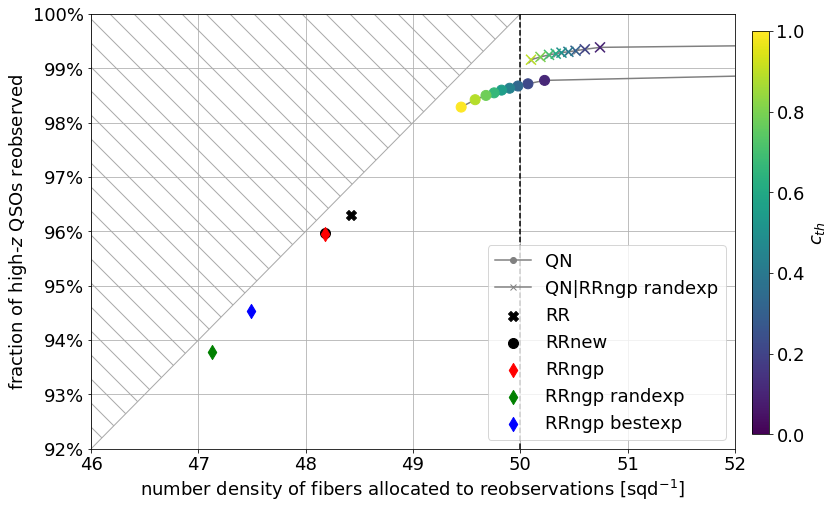

In [76]:
## Compare redrock version of plot

# Number of expected high-z QSOs per square degree in DESI
n_highz_desi = 50
eff_area = ((data_table['ISQSO_VI'] & (data_table['ZCONF_PERSON']==2) & (data_table['Z_VI']>=2.1)).sum())/n_highz_desi

# Cut to define high-z QSOs.
zcut = 2.1
# Maximum velocity error to be considered a correct classification.
dv_max = 6000. # km/s

# QN confidence thresholds.
cth_min = 0.0
cth_max = 1.0
n_int = 10
c_th = np.arange(cth_min,cth_max,(1/n_int)*(cth_max-cth_min))

# QN classifications.
highz_qn = data_table['Z_QN']>=zcut

# RR classifications.
isqso_rr = data_table['ISQSO_RR']
highz_rr = data_table['Z_RR']>=zcut

# RRnew classifications.
isqso_rrnew = data_table['ISQSO_RRnew']
highz_rrnew = data_table['Z_RRnew']>=zcut

# RRngp classifications.
isqso_rrngp = data_table['ISQSO_RRngp']
highz_rrngp = data_table['Z_RRngp']>=zcut

# RRngp randexp classifications.
isqso_rrngpr = data_table['ISQSO_RRngp randexp']
highz_rrngpr = data_table['Z_RRngp randexp']>=zcut

# RRngp bestexp classifications.
isqso_rrngpb = data_table['ISQSO_RRngp bestexp']
highz_rrngpb = data_table['Z_RRngp bestexp']>=zcut

# Define the strategies.
strategies = {}

strategies['QN'] = {'w': [(data_table['CMAX_QN']>cth)&(data_table['Z_QN']>zcut) for cth in c_th],
                    'nhighz_flagged': np.zeros(c_th.shape),
                    'nhighz_truth_flagged': np.zeros(c_th.shape),
                    'color': c_th,
                    'marker': 'o',
                   }

strategies['RR'] = {'w': [isqso_rr & highz_rr],
                    'nhighz_flagged': np.zeros(1),
                    'nhighz_truth_flagged': np.zeros(1),
                    'color': 'k',
                    'marker': 'X',
                   }

strategies['RRnew'] = {'w': [isqso_rrnew & highz_rrnew],
                    'nhighz_flagged': np.zeros(1),
                    'nhighz_truth_flagged': np.zeros(1),
                    'color': 'k',
                    'marker': 'o',
                   }

strategies['RRngp'] = {'w': [isqso_rrngp & highz_rrngp],
                    'nhighz_flagged': np.zeros(1),
                    'nhighz_truth_flagged': np.zeros(1),
                    'color': 'red',
                    'marker': 'd',
                   }

strategies['RRngp randexp'] = {'w': [isqso_rrngpr & highz_rrngpr],
                    'nhighz_flagged': np.zeros(1),
                    'nhighz_truth_flagged': np.zeros(1),
                    'color': 'green',
                    'marker': 'd',
                   }

strategies['RRngp bestexp'] = {'w': [isqso_rrngpb & highz_rrngpb],
                    'nhighz_flagged': np.zeros(1),
                    'nhighz_truth_flagged': np.zeros(1),
                    'color': 'blue',
                    'marker': 'd',
                   }

strategies['QN|RRngp randexp'] = {'w': [((isqso_rrngpr & highz_rrngpr) | (data_table['CMAX_QN']>cth)&(data_table['Z_QN']>zcut)) for cth in c_th],
                    'nhighz_flagged': np.zeros(c_th.shape),
                    'nhighz_truth_flagged': np.zeros(c_th.shape),
                    'color': c_th,
                    'marker': 'x',
                   }

"""strategies['QN|RRngp bestexp'] = {'w': [((isqso_rrngpb & highz_rrngpb) | (data_table['CMAX_QN']>cth)&(data_table['Z_QN']>zcut)) for cth in c_th],
                    'nhighz_flagged': np.zeros(c_th.shape),
                    'nhighz_truth_flagged': np.zeros(c_th.shape),
                    'color': c_th,
                    'marker': 'v',
                   }
"""

# Make the plot.
filename = '../plots/classifier_performance_selecting_for_reobservation_rrtest.pdf'
fig, ax = plt.subplots(1,1,figsize=(figsize[0],figsize[1]))
make_plot(fig,ax,data_table,strategies,filename,c_th,eff_area,dv_max,zcut=zcut,ymin=0.92,xmin=46)